In [ ]:
+-%tensorflow_version 1.x  #to decrease my tensorflow version
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  #to decrease my tensorflow version`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [ ]:
#import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, activations
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.image import img_to_array, load_img


Using TensorFlow backend.


**Loading Images**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/dogs-vs-cats.zip"
with ZipFile(file_name, "r") as zip:
  zip.extractall()
  print('done')

done


**Prepare dataset for training model:**

In [ ]:
train_names = os.listdir("/content/dogs-vs-cats/train/train")

categories = []
for train_image in train_names:
  category = train_image.split(".")[0]
  if category == "dog":
    categories.append(1)
  else:
    categories.append(0)

In [ ]:
df = pd.DataFrame({"file name":train_names,
                   "category":categories})
df.head()

,file name,category
0,dog.3909.jpg,1
1,dog.7972.jpg,1
2,dog.5141.jpg,1
3,cat.5793.jpg,0
4,dog.7842.jpg,1


**image properties:**

In [ ]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

**Neural net model:**

In [ ]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

#model compiling 
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

**Callbacks and Learning rate:**

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", verbose = 1, factor = 0.5, min_lr=0.00001)
callbacks = [early_stop, learning_rate_reduction]

In [ ]:
df['category'] = df['category'].replace({0:'cat', 1:'dog'})
#df.head()

train_df, val_df = train_test_split(df,test_size=0.20,
  random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=val_df.shape[0]
batch_size=15
test_batch = 20

**Data Augumentation**

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "/content/dogs-vs-cats/train/train",x_col='file name',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)


validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    val_df, 
    "/content/dogs-vs-cats/train/train", 
    x_col='file name',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)
test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)


test_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "/content/dogs-vs-cats/train/train",x_col='file name',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=test_batch)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
#train_generator.shape()

AttributeError: ignored

**Model Training**

In [ ]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1333/1333 [==============================] - 145s 109ms/step - loss: 0.7340 - acc: 0.6372 - val_loss: 0.5401 - val_acc: 0.7337
Epoch 2/10
1333/1333 [==============================] - 137s 103ms/step - loss: 0.5605 - acc: 0.7191 - val_loss: 0.5210 - val_acc: 0.7590
Epoch 3/10
1333/1333 [==============================] - 136s 102ms/step - loss: 0.5111 - acc: 0.7537 - val_loss: 0.5424 - val_acc: 0.7387
Epoch 4/10
1333/1333 [==============================] - 138s 104ms/step - loss: 0.4724 - acc: 0.7805 - val_loss: 0.6203 - val_acc: 0.7293
Epoch 5/10
1333/1333 [==============================] - 136s 102ms/step - loss: 0.4364 - acc: 0.7992 - val_loss: 0.4383 - val_acc: 0.7994
Epoch 6/10
1333/1333 [==============================] - 136s 102ms/step - loss: 0.4204 - acc: 0.8124 - val_loss: 0.3415 - val_acc: 0.8547
Epoch 7/10
1333/1333 [==============================] - 136s 102ms/step - loss: 0.4044 - acc: 0.8147 - val_loss: 0.4946 - val_acc: 0.7664
Epoch 8/10
1333/1333 [============

**Saving the model**

In [ ]:
model.save("c&g.h5")

**Test Data Preparation**

In [ ]:
test_data = os.listdir("/content/dogs-vs-cats/test1/test1")
test_df = pd.DataFrame({
    'filename': test_data
})
nb_samples = test_df.shape[0]

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/test_batch))

**Convert labels to categories:**

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
len(os.listdir("/content/dogs-vs-cats/test1/test1"))

12500

**Visualize the prediction results:**

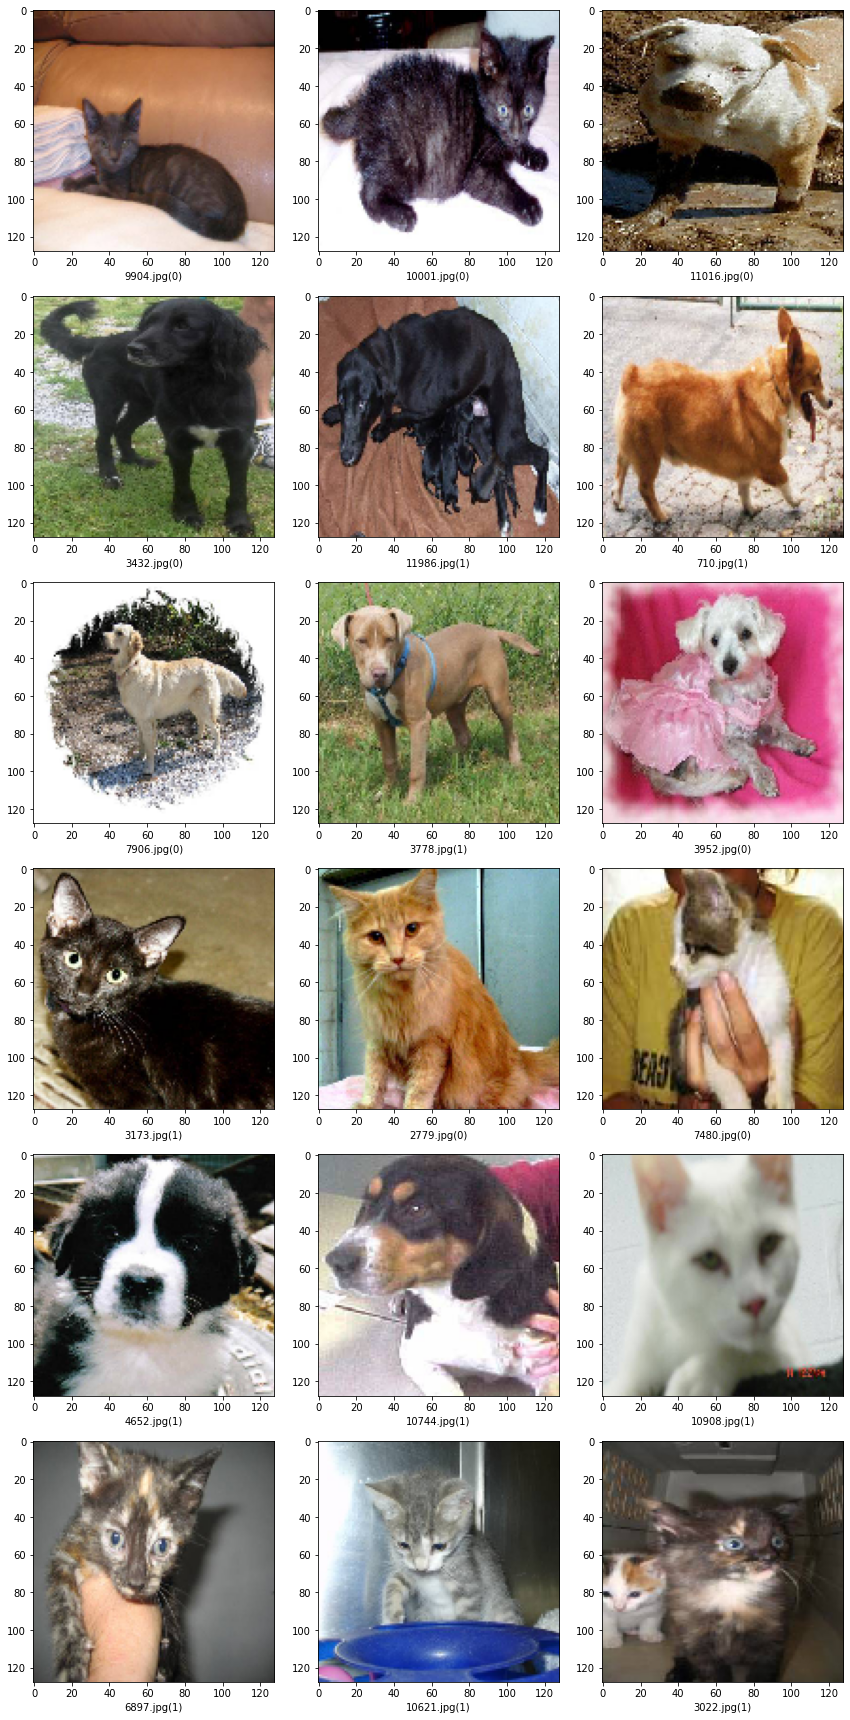

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/dogs-vs-cats/test1/test1/"+ filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show() 

**Test your model performance on custom data:**

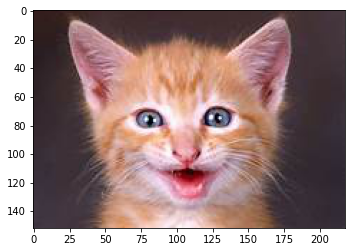

In [ ]:
import matplotlib.image as mpimg
image = mpimg.imread("/content/cat1.jpg")
plt.imshow(image)
plt.show()

In [ ]:
results={
    0:'cat',
    1:'dog'
}
from PIL import Image
import numpy as np
im=Image.open("/content/cat1.jpg")
im=im.resize(Image_Size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict_classes([im])[0]
print(pred,results[pred])

0 cat


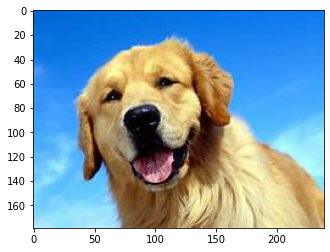

In [ ]:
image = mpimg.imread("/content/dog2.jpg")
plt.imshow(image)
plt.show()

In [ ]:
im=Image.open("/content/dog2.jpg")
im=im.resize(Image_Size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict_classes([im])[0]
print(pred,results[pred])

1 dog


In [ ]:
# import tkinter as tk
# from tkinter import filedialog
# from tkinter import *
# from PIL import ImageTk, Image
# import numpy

# from keras.models import load_model
# model = load_model('model1_catsVSdogs_10epoch.h5')
# #dictionary to label all traffic signs class.
# classes = { 
#     0:'its a cat',
#     1:'its a dog',
 
# }
# #initialise GUI
# top=tk.Tk()
# top.geometry('800x600')
# top.title('CatsVSDogs Classification')
# top.configure(background='#CDCDCD')
# label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
# sign_image = Label(top)
# def classify(file_path):
#     global label_packed
#     image = Image.open(file_path)
#     image = image.resize((128,128))
#     image = numpy.expand_dims(image, axis=0)
#     image = numpy.array(image)
#     image = image/255
#     pred = model.predict_classes([image])[0]
#     sign = classes[pred]
#     print(sign)
#     label.configure(foreground='#011638', text=sign) 
# def show_classify_button(file_path):
#     classify_b=Button(top,text="Classify Image",
#    command=lambda: classify(file_path),
#    padx=10,pady=5)
#     classify_b.configure(background='#364156', foreground='white',
# font=('arial',10,'bold'))
#     classify_b.place(relx=0.79,rely=0.46)

# def upload_image():
#     try:
#         file_path=filedialog.askopenfilename()
#         uploaded=Image.open(file_path)
#         uploaded.thumbnail(((top.winfo_width()/2.25),
#     (top.winfo_height()/2.25)))
#         im=ImageTk.PhotoImage(uploaded)
#         sign_image.configure(image=im)
#         sign_image.image=im
#         label.configure(text='')
#         show_classify_button(file_path)
#     except:
#         pass
# upload=Button(top,text="Upload an image",command=upload_image,padx=10,pady=5)
# upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
# upload.pack(side=BOTTOM,pady=50)
# sign_image.pack(side=BOTTOM,expand=True)
# label.pack(side=BOTTOM,expand=True)
# heading = Label(top, text="CatsVSDogs Classification",pady=20, font=('arial',20,'bold'))
# heading.configure(background='#CDCDCD',foreground='#364156')
# heading.pack()
# top.mainloop()